In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset, namely [RUGD](http://rugd.vision/). In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [1]:
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset


class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "annotations")
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          print(files)
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        annotation = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # make 2D segmentation map (based on 3D one)
        # thanks a lot, Stackoverflow: https://stackoverflow.com/questions/61897492/finding-the-number-of-pixels-in-a-numpy-array-equal-to-a-given-color
        annotation = np.array(annotation)
        annotation_2d = np.zeros((annotation.shape[0], annotation.shape[1]), dtype=np.uint8) # height, width

        for id, color in id2color.items():
          annotation_2d[(annotation == color).all(axis=-1)] = id

        # randomly crop + pad both image and segmentation map to same size
        # feature extractor will also reduce labels!
        encoded_inputs = self.feature_extractor(image, Image.fromarray(annotation_2d), return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [2]:
import pandas as pd

# read in RUGD's color palette
color_map = pd.read_csv('F:/Major Project/RUGD_annotation-colormap.txt',
                              sep=" ",
                              header=None)
color_map.columns = ["label_idx", "label", "R", "G", "B"]
color_map.head()

,label_idx,label,R,G,B
0,0,void,0,0,0
1,1,dirt,108,64,20
2,2,sand,255,229,204
3,3,grass,0,102,0
4,4,tree,0,255,0


In [3]:
label2id = {label: id for id, label in enumerate(color_map.label)}
id2label = {id: label for id, label in enumerate(color_map.label)}
print(id2label)

{0: 'void', 1: 'dirt', 2: 'sand', 3: 'grass', 4: 'tree', 5: 'pole', 6: 'water', 7: 'sky', 8: 'vehicle', 9: 'container/generic-object', 10: 'asphalt', 11: 'gravel', 12: 'building', 13: 'mulch', 14: 'rock-bed', 15: 'log', 16: 'bicycle', 17: 'person', 18: 'fence', 19: 'bush', 20: 'sign', 21: 'rock', 22: 'bridge', 23: 'concrete', 24: 'picnic-table'}


In [4]:
len(id2label)

25

In [5]:
id2color = {id: [R,G,B] for id, (R,G,B) in enumerate(zip(color_map.R, color_map.G, color_map.B))}
print(id2color)

{0: [0, 0, 0], 1: [108, 64, 20], 2: [255, 229, 204], 3: [0, 102, 0], 4: [0, 255, 0], 5: [0, 153, 153], 6: [0, 128, 255], 7: [0, 0, 255], 8: [255, 255, 0], 9: [255, 0, 127], 10: [64, 64, 64], 11: [255, 128, 0], 12: [255, 0, 0], 13: [153, 76, 0], 14: [102, 102, 0], 15: [102, 0, 0], 16: [0, 255, 128], 17: [204, 153, 255], 18: [102, 0, 204], 19: [255, 153, 204], 20: [0, 102, 102], 21: [153, 204, 255], 22: [102, 255, 255], 23: [101, 101, 11], 24: [114, 85, 47]}


In [6]:
id2color[label2id["tree"]]

[0, 255, 0]

Let's initialize the training dataset. 

As we can see above, the dataset includes a "void" class (with id=0). However, this class isn't included in the annotation maps (the "void" class isn't part of the 24 labels), hence we initialize the feature extractor with `reduce_labels=True` to make it reduce all labels by one.

This makes sure that the ground truth label tensors contain values between 0 and 23.



In [7]:
from transformers import SegformerFeatureExtractor

root_dir = 'F:/Major Project/RUGD_sample-data'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)

['creek_00001.png', 'creek_02001.png', 'park-1_00001.png', 'park-1_02001.png', 'park-2_00501.png', 'park-2_02001.png', 'park-8_00001.png', 'trail-10_00001.png', 'trail-11_00001.png', 'trail-11_02001.png', 'trail-12_00501.png', 'trail-13_00001.png', 'trail-14_01001.png', 'trail-15_00001.png', 'trail-3_00001.png', 'trail-3_02001.png', 'trail-4_00001.png', 'trail-4_02001.png', 'trail-5_00001.png', 'trail-6_00001.png', 'trail-6_02001.png', 'trail-7_00001.png', 'trail-9_00001.png', 'trail_00001.png', 'trail_02001.png', 'village_00003.png']


In [8]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 26


Let's verify a random example:

In [9]:
encoded_inputs = train_dataset[0]

In [10]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [11]:
encoded_inputs["labels"].shape

torch.Size([512, 512, 3])

In [12]:
encoded_inputs["labels"]

tensor([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 228, 203],
         [255, 228, 203],
         [255, 228, 203],
         ...,
         [101, 101, 255],
         [101, 101, 255],
         [101, 101, 255]],

        [[255, 228, 203],
         [255, 228, 203],
         [255, 228, 203],
         ...,
         [101, 101, 255],
         [101, 101, 255],
         [101, 101, 255]],

        [[255, 228, 203],
         [255, 228, 203],
         [255, 228, 203],
         ...,
         [101, 101, 255],
        

In [13]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 19,  63, 101, 107, 126, 127, 152, 203, 228, 255])

Next, we define a corresponding dataloader.

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [15]:
batch = next(iter(train_dataloader))

In [16]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512, 3])


In [17]:
batch["labels"].shape

torch.Size([2, 512, 512, 3])

In [18]:
mask = (batch["labels"] != 255)
mask

tensor([[[[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],

         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],

         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],

         ...,

         [[ True,  True, False],
          [ True,  True, False],
          [ True,  True, False],
          ...,
          [ True,  True, False],
          [ True,  True, False],
          [ True,  True, False]],

         [[ True,  True, False],
          [ True,  True, False],
          [ True,  True, False],
          ...,
          [

In [19]:
batch["labels"][mask]

tensor([101, 101, 101,  ..., 101, 101, 101])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

As we've reduced all labels by one above, we need to update our `id2color` and `id2label` mappings first.

In [20]:
del id2color[0]

id2color = {id-1: color for id, color in id2color.items()}
print(id2color)

{0: [108, 64, 20], 1: [255, 229, 204], 2: [0, 102, 0], 3: [0, 255, 0], 4: [0, 153, 153], 5: [0, 128, 255], 6: [0, 0, 255], 7: [255, 255, 0], 8: [255, 0, 127], 9: [64, 64, 64], 10: [255, 128, 0], 11: [255, 0, 0], 12: [153, 76, 0], 13: [102, 102, 0], 14: [102, 0, 0], 15: [0, 255, 128], 16: [204, 153, 255], 17: [102, 0, 204], 18: [255, 153, 204], 19: [0, 102, 102], 20: [153, 204, 255], 21: [102, 255, 255], 22: [101, 101, 11], 23: [114, 85, 47]}


In [22]:
del id2label[0]

label2id = {label: id-1 for id, label in id2label.items()}
id2label = {id-1: label for id, label in id2label.items()}
print(id2label)

{0: 'dirt', 1: 'sand', 2: 'grass', 3: 'tree', 4: 'pole', 5: 'water', 6: 'sky', 7: 'vehicle', 8: 'container/generic-object', 9: 'asphalt', 10: 'gravel', 11: 'building', 12: 'mulch', 13: 'rock-bed', 14: 'log', 15: 'bicycle', 16: 'person', 17: 'fence', 18: 'bush', 19: 'sign', 20: 'rock', 21: 'bridge', 22: 'concrete', 23: 'picnic-table'}


In [23]:
from transformers import SegformerForSemanticSegmentation

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=24, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_nor

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [24]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [25]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # we use _compute for now which fixes an issue in speed
          # see this Github thread for more info: 
          metrics = metric._compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
                                   predictions=predicted.detach().cpu().numpy(),
                                    references=labels.detach().cpu().numpy()
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

f:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch: 0


  0%|          | 0/13 [00:00<?, ?it/s]

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [2, 512, 512, 3]

## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

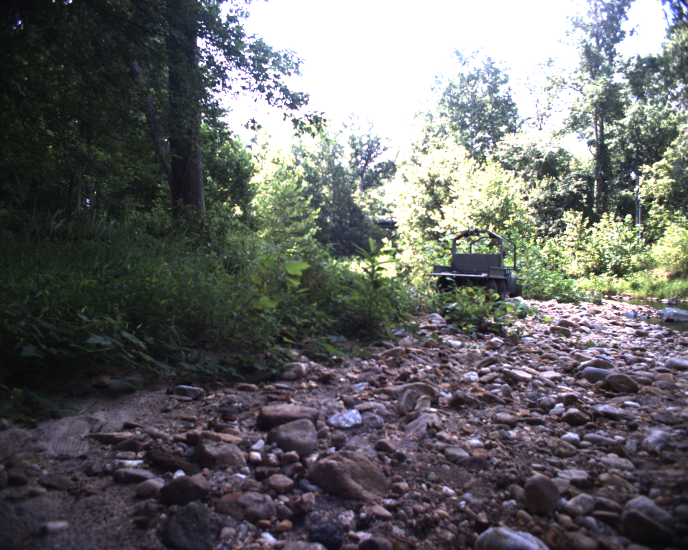

In [48]:
image = Image.open('F:/Major Project/RUGD_sample-data/images/creek_00001.png')
image

In [49]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [50]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [51]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])


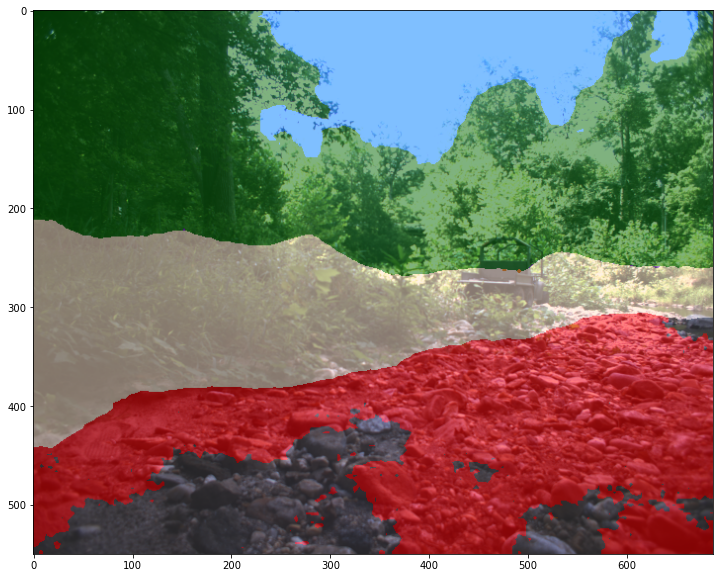

In [52]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[seg == label, :] = color

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's print the pure predicted segmentation map:

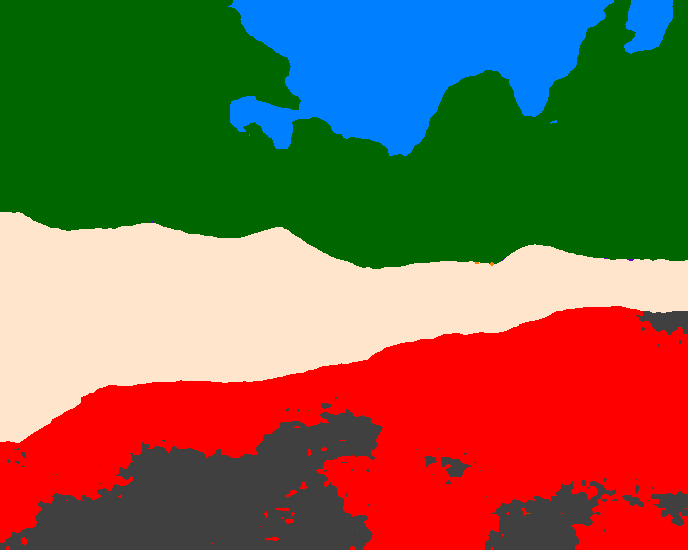

In [53]:
Image.fromarray(color_seg)

Compare this to the ground truth segmentation map:

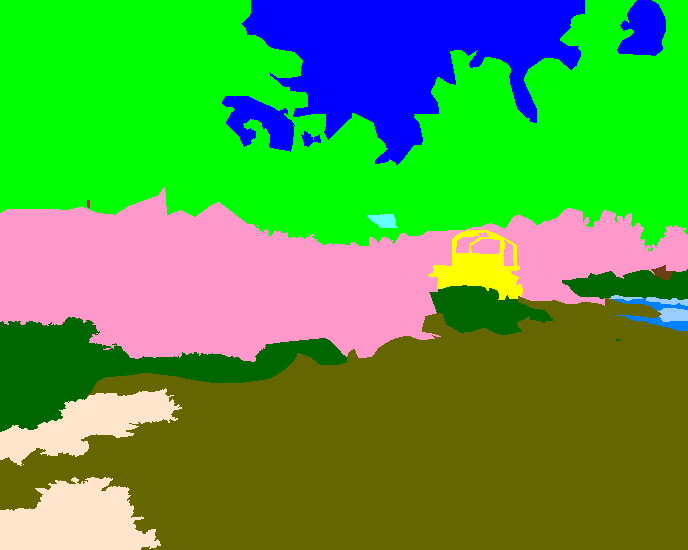

In [54]:
map = Image.open('F:/Major Project/RUGD_sample-data/annotations/creek_00001.png') 
map 